In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')

In [4]:
data = data.drop(['ID#'], axis=1, errors='ignore')

In [5]:
data.dropna(inplace=True)

In [6]:
from scipy import stats
z_scores = np.abs(stats.zscore(data))
data = data[(z_scores < 3).all(axis=1)]

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [8]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

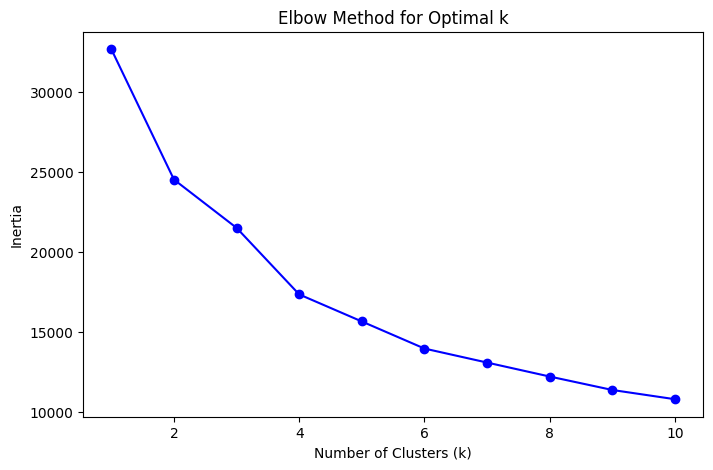

In [9]:
# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [10]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

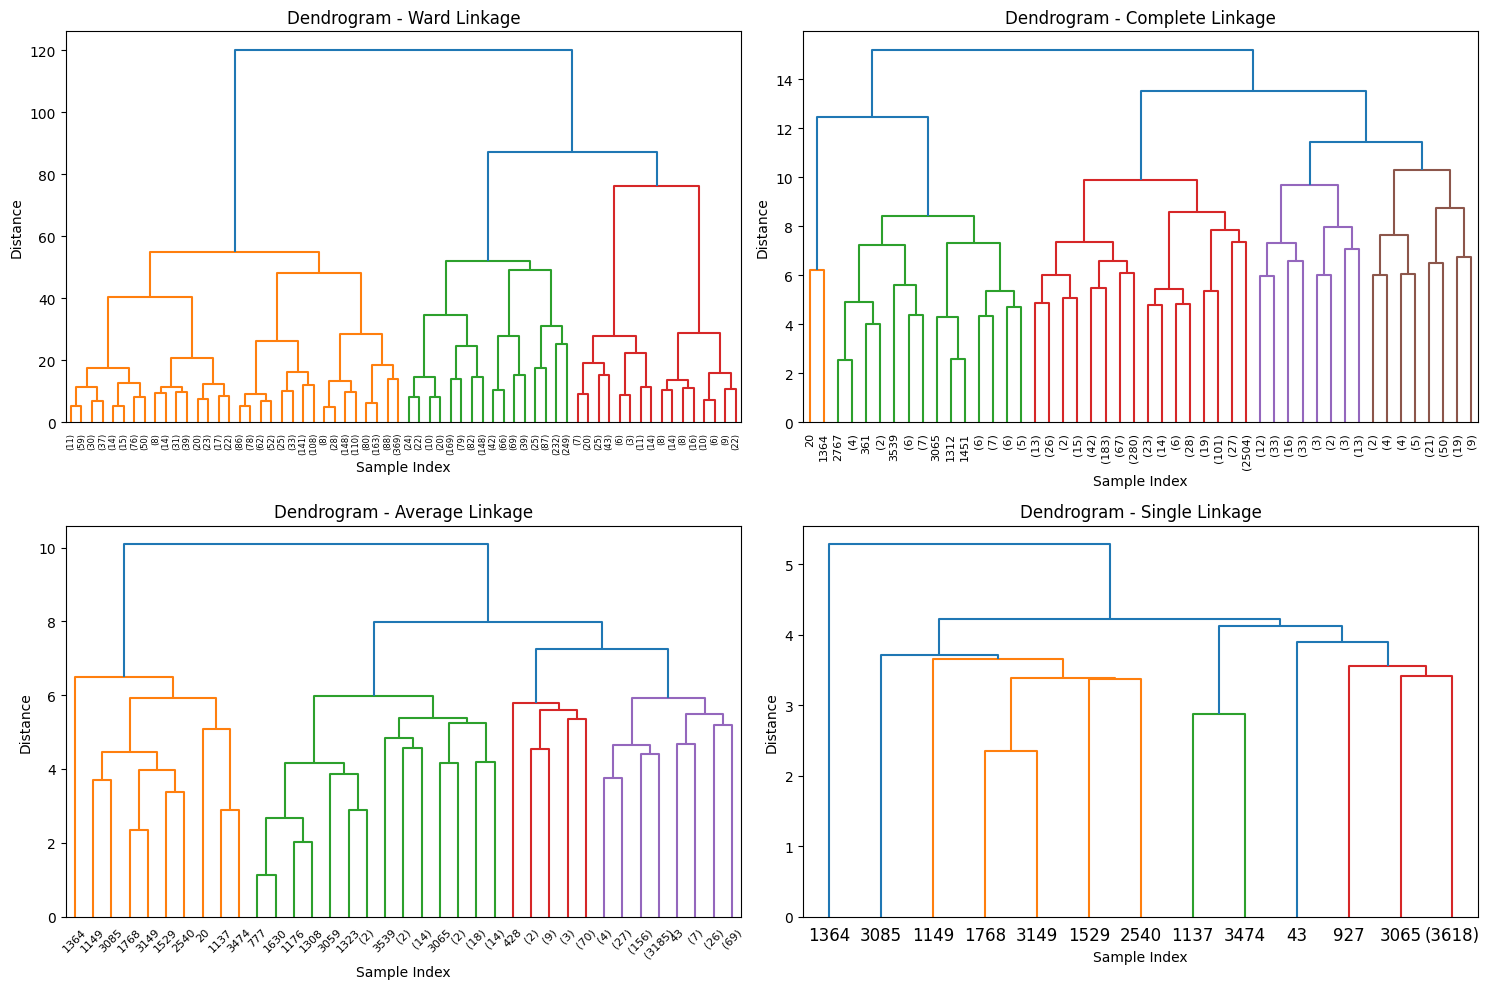

In [12]:
# Hierarchical Clustering with Different Linkage Methods
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_labels = {}
plt.figure(figsize=(15, 10))
for i, method in enumerate(linkage_methods, 1):
    # Compute linkage matrix
    Z = linkage(scaled_data, method=method)
    plt.subplot(2, 2, i)
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title(f'Dendrogram - {method.capitalize()} Linkage')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
plt.show()

In [14]:
#Apply Hierarchical Clustering with optimal clusters (e.g., n_clusters=4)
for method in linkage_methods:
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage=method)
    hierarchical_labels[method] = agglomerative.fit_predict(scaled_data)

In [15]:
neighbors = NearestNeighbors(n_neighbors=22)  # 2 * number of features (assuming ~11 features)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

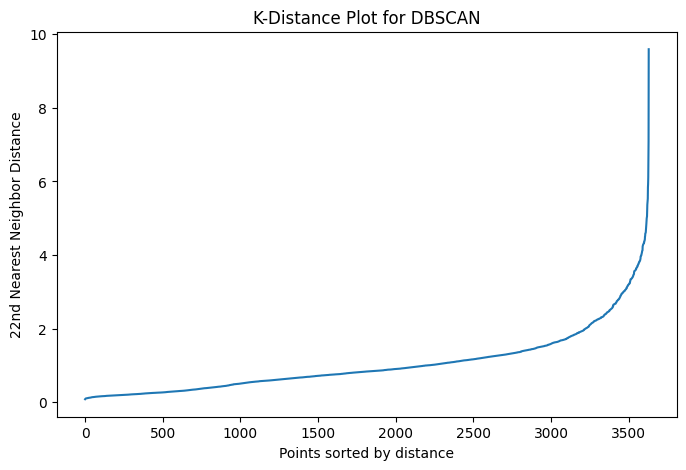

In [16]:
distances = np.sort(distances[:, 21], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Plot for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('22nd Nearest Neighbor Distance')
plt.show()

In [17]:
dbscan = DBSCAN(eps=1.5, min_samples=22)
dbscan_labels = dbscan.fit_predict(scaled_data)

In [18]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0, 0.5, 'Feature 2')

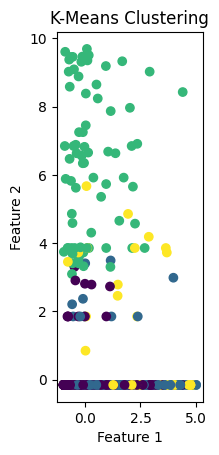

In [19]:
# K-Means
plt.subplot(1, 3, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

Text(0, 0.5, 'Feature 2')

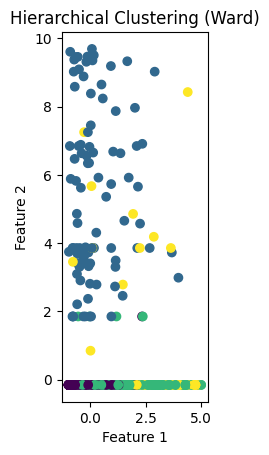

In [20]:
plt.subplot(1, 3, 2)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=hierarchical_labels['ward'], cmap='viridis')
plt.title('Hierarchical Clustering (Ward)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

Text(0, 0.5, 'Feature 2')

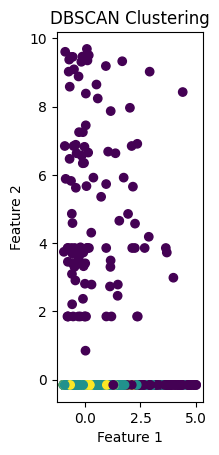

In [21]:
plt.subplot(1, 3, 3)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [22]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [23]:
kmeans_silhouette_score = silhouette_score(scaled_data, kmeans_labels)
print('K-Means Silhouette Score:', kmeans_silhouette_score)

K-Means Silhouette Score: 0.3316635667716135


In [24]:
# Silhouette scores for Hierarchical Clustering with different linkages
for method in linkage_methods:
    score = silhouette_score(scaled_data, hierarchical_labels[method])
    print(f'Hierarchical Clustering ({method.capitalize()} Linkage) Silhouette Score:', score)

Hierarchical Clustering (Ward Linkage) Silhouette Score: 0.29744887783615376
Hierarchical Clustering (Complete Linkage) Silhouette Score: 0.4546819845362683
Hierarchical Clustering (Average Linkage) Silhouette Score: 0.5071177316752706
Hierarchical Clustering (Single Linkage) Silhouette Score: 0.5704384655031923


In [25]:
# Silhouette score for DBSCAN (only if more than one cluster and no noise-only clusters)
if len(np.unique(dbscan_labels)) > 1 and -1 not in np.unique(dbscan_labels):
    dbscan_silhouette_score = silhouette_score(scaled_data, dbscan_labels)
    print('DBSCAN Silhouette Score:', dbscan_silhouette_score)
else:
    print('DBSCAN Silhouette Score: Not computed (single cluster or noise-only)')

DBSCAN Silhouette Score: Not computed (single cluster or noise-only)


In [26]:
# Summary of cluster counts
print('\nCluster Counts:')
print('K-Means:', np.bincount(kmeans_labels))
for method in linkage_methods:
    print(f'Hierarchical ({method.capitalize()}):', np.bincount(hierarchical_labels[method]))
print('DBSCAN:', np.bincount(dbscan_labels + 1))  # Adjust for -1 (noise)


Cluster Counts:
K-Means: [2134 1188   72  236]
Hierarchical (Ward): [2045   93 1363  129]
Hierarchical (Complete): [ 229   49 3350    2]
Hierarchical (Average): [  10 3475   60   85]
Hierarchical (Single): [3621    2    6    1]
DBSCAN: [ 404 2244  982]
